## Import Libraries

In [1]:
!pip install keras_cv

In [2]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import requests
from io import BytesIO
import cv2
from PIL import Image
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight
import seaborn as sns
import keras_cv.layers as kcvl

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.16.1


In [3]:
import albumentations as A
import numpy as np
import matplotlib.pyplot as plt
import random

In [4]:
pip install --upgrade albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.9/227.9 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 606.4/606.4 kB 3.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.7/291.7 kB 20.7 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.17
    Uninstalling albucore-0.0.17:
      Successfully uninstalled albucore-0.0.17
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.17
    Uninstalling albumentations-1.4.17:
      Successfully uninstalled albumentations-1.4.17
Note: you may need to restart the kernel to use updated packages.


## Load and Split Data

In [10]:
#Load dataset
data = np.load('/kaggle/input/blood-cells-dataset/training_set.npz')
X = data['images']
y = data['labels']

In [11]:
#Excluding problematic images and outliers from the model (see Data_Preprocessing.ipynb).
X = X[:11958]
y = y[:11958]
classes = np.array(np.unique(y))
class_names = ['Basophil','Eosinophil','Erythroblast','Immature granulocytes','Lymphocyte','Monocyte','Neutrophil','Platelet']
print(classes)
print(class_names)

[0 1 2 3 4 5 6 7]
['Basophil', 'Eosinophil', 'Erythroblast', 'Immature granulocytes', 'Lymphocyte', 'Monocyte', 'Neutrophil', 'Platelet']


In [12]:
# Make sure that y is a flat array of integer values.
y_flat = np.array(y).flatten()  #Convert y into a flat array, if it isn’t already.

# Get the unique classes in y_flat.
classes = np.unique(y_flat)

# Calculation of class weights.
class_weights = compute_class_weight('balanced', classes=classes, y=y_flat)

# Conversion of class weights to a dictionary.
class_weights_dict = dict(enumerate(class_weights))

# Print class weights.
print(class_weights_dict)

{0: 1.7544014084507042, 1: 0.6853507565337001, 2: 1.3776497695852534, 3: 0.7377838104639685, 4: 1.762676886792453, 5: 1.505287009063444, 6: 0.6415236051502146, 7: 0.9097687157638467}


In [13]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=0.25, stratify=y)

# Split test set into validation and test sets with stratification
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, random_state=seed, test_size=0.5, stratify=y_test)

# Convert targets to categorical
y_train = tfk.utils.to_categorical(y_train, num_classes=len(class_names))
y_val = tfk.utils.to_categorical(y_val, num_classes=len(class_names))
y_test = tfk.utils.to_categorical(y_test, num_classes=len(class_names))

# Print datasets' shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (8968, 96, 96, 3), y_train shape: (8968, 8)
X_val shape: (1495, 96, 96, 3), y_val shape: (1495, 8)
X_test shape: (1495, 96, 96, 3), y_test shape: (1495, 8)


## Data Augmentation

In [15]:
# Define a transformation pipeline.
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=45, p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.HueSaturationValue(hue_shift_limit=40, sat_shift_limit=30, val_shift_limit=20, p=0.3),
    A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1, p=0.3),
    A.Defocus(radius=(1,3), alias_blur=(0.5, 0.5), p=0.3),
    A.CLAHE(clip_limit=(3, 3), tile_grid_size=(8, 8), p=0.3),
    A.Downscale(scale_range=(0.5, 0.75), interpolation_pair={'downscale': cv2.INTER_NEAREST, 'upscale': cv2.INTER_LINEAR}, p=0.3),
    A.GaussNoise(p=0.2),
    A.RandomCrop(height=70,width=70, p=0.3),
    A.RandomScale(scale_limit=0.6, p=0.2),
    A.Resize(96, 96)  #Ensure that all images are 96x96.
])

In [16]:
# Apply transformations to the entire training dataset.
X_augmented = []

for img in X_train:
    augmented = transform(image=img)  #Pass the image as the named argument.
    X_augmented.append(augmented["image"])

# Convert the transformed dataset into a NumPy array.
X_augmented = np.array(X_augmented)

In [18]:
print(f"X_train shape: {X_train.shape}, X_augmented shape: {X_augmented.shape}")

X_train shape: (8968, 96, 96, 3), X_augmented shape: (8968, 96, 96, 3)


## Build Model



In [19]:
from keras.applications.efficientnet_v2 import EfficientNetV2L

In [20]:
from tensorflow.keras.layers import LayerNormalization, GroupNormalization

In [21]:
# Initialise EfficientNetV2-L model with pretrained weights, for transfer learning
eff = tfk.applications.EfficientNetV2L(
    input_shape=(96, 96, 3),
    include_top=False,
    weights='imagenet',
    include_preprocessing=True,
)
eff.trainable = False

473176280/473176280 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


In [22]:
# Optimizer with exponential decay
optimizer = tf.keras.optimizers.Lion(1e-4)

# ReduceLROnPlateau for fine adjustments
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',  # Monitor validation accuracy
    factor=0.5,              # Halve the learning rate
    patience=5,             # Wait 10 epochs for no improvement
    min_lr=1e-6,             # Minimum learning rate
    verbose=1                # Log learning rate changes
)

In [23]:
#DEF OF CUSTOM MODEL
def build_eff_aug(input_shape=(96, 96, 3)):

    """Build a EfficientNetV2L based CNN with image augmentation"""

    # Input layer
    inputs = tfk.Input(shape=(96, 96, 3), name='input_layer')

    # EfficientNet base model
    x = eff(inputs)

    # Inception Block
    def inception_block(inputs):
        tower_1 = tfkl.Conv2D(64, (1, 1), activation='relu')(inputs)
        tower_1 = tfkl.Conv2D(64, (3, 3), padding='same', activation='relu')(tower_1)

        tower_2 = tfkl.Conv2D(64, (1, 1), activation='relu')(inputs)
        tower_2 = tfkl.Conv2D(64, (5, 5), padding='same', activation='relu')(tower_2)

        tower_3 = tfkl.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(inputs)
        tower_3 = tfkl.Conv2D(64, (1, 1), activation='relu')(tower_3)

        output = tfkl.concatenate([tower_1, tower_2, tower_3], axis=-1)
        return output

    x = inception_block(x)

    # Flatten and fully connected layers with Group Normalization
    x = tfkl.Flatten()(x)
    x = tfkl.Dropout(0.5)(x)
    x = GroupNormalization(groups=8, axis=-1)(x)  # Group Normalization (8 groups, default channel axis)
    x = tfkl.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-5), name='dense_1024')(x)
    x = tfkl.Dropout(0.4)(x)
    x = GroupNormalization(groups=8, axis=-1)(x)
    x = tfkl.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-5), name='dense_512')(x)
    x = tfkl.Dropout(0.3)(x)
    x = GroupNormalization(groups=8, axis=-1)(x)
    x = tfkl.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-5), name='dense_256')(x)
    x = tfkl.Dropout(0.2)(x)
    x = GroupNormalization(groups=8, axis=-1)(x)
    x = tfkl.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-5), name='dense_128')(x)
    x = tfkl.Dropout(0.1)(x)

    # Output layer
    outputs = tfkl.Dense(y_train.shape[-1], activation='softmax', name='dense')(x)

    # Final model
    model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

    # Compile the model
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        optimizer=optimizer,
        metrics=['accuracy']
    )
    # Return the model
    return model

## Transfer Learning on EfficientNetV2-L



In [24]:
# Build an EfficientNetV2-L based custom  model for transfer learning
tl_model_eff = build_eff_aug()

# Train the model
tl_history_eff = tl_model_eff.fit(
    x=X_augmented,
    y=y_train,
    batch_size=64,
    epochs=150,
    validation_data=(X_val, y_val),
    class_weight = class_weights_dict,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True
        ),
        reduce_lr  # Add dynamic learning rate adjustment
    ]
).history

# Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(tl_history_eff['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
model_filename = 'CNN_' + str(final_val_accuracy) + '.keras'
tl_model_eff.save(model_filename)

# Save weights of the Transfer Learning model
tl_model_eff.save_weights('tl.weights.h5')

Epoch 1/150


I0000 00:00:1732356439.588907     135 service.cc:145] XLA service 0x7c3d08002170 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732356439.588961     135 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732356439.588965     135 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1732356587.581534     135 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


141/141 ━━━━━━━━━━━━━━━━━━━━ 378s 1s/step - accuracy: 0.1484 - loss: 2.3335 - val_accuracy: 0.2080 - val_loss: 1.8280 - learning_rate: 1.0000e-04
Epoch 2/150
141/141 ━━━━━━━━━━━━━━━━━━━━ 22s 157ms/step - accuracy: 0.2577 - loss: 1.8881 - val_accuracy: 0.5625 - val_loss: 1.3540 - learning_rate: 1.0000e-04
Epoch 3/150
141/141 ━━━━━━━━━━━━━━━━━━━━ 22s 153ms/step - accuracy: 0.7359 - loss: 1.1134 - val_accuracy: 0.8515 - val_loss: 0.8686 - learning_rate: 1.0000e-04
Epoch 8/150
141/141 ━━━━━━━━━━━━━━━━━━━━ 21s 149ms/step - accuracy: 0.7521 - loss: 1.0695 - val_accuracy: 0.8515 - val_loss: 0.8560 - learning_rate: 1.0000e-04
Epoch 9/150
141/141 ━━━━━━━━━━━━━━━━━━━━ 22s 153ms/step - accuracy: 0.7693 - loss: 1.0451 - val_accuracy: 0.8562 - val_loss: 0.8367 - learning_rate: 1.0000e-04
Epoch 10/150
141/141 ━━━━━━━━━━━━━━━━━━━━ 22s 153ms/step - accuracy: 0.7801 - loss: 1.0083 - val_accuracy: 0.8642 - val_loss: 0.8301 - learning_rate: 1.0000e-04
Epoch 11/150
141/141 ━━━━━━━━━━━━━━━━━━━━ 22s 153ms/s

In [28]:
from tensorflow.keras.models import load_model
model = load_model('CNN_92.64.keras')

In [29]:
#All layers of EfficientNetV2-L are initially frozen.
for i, layer in enumerate(model.get_layer('efficientnetv2-l').layers):
    print(f"Layer {i}: {layer.name}, Trainable: {layer.trainable}")

Layer 0: input_layer, Trainable: True
Layer 1: rescaling, Trainable: False
Layer 2: stem_conv, Trainable: False
Layer 3: stem_bn, Trainable: False
Layer 4: stem_activation, Trainable: False
Layer 5: block1a_project_conv, Trainable: False
Layer 6: block1a_project_bn, Trainable: False
Layer 7: block1a_project_activation, Trainable: False
Layer 8: block1a_add, Trainable: False
Layer 9: block1b_project_conv, Trainable: False
Layer 10: block1b_project_bn, Trainable: False
Layer 11: block1b_project_activation, Trainable: False
Layer 12: block1b_drop, Trainable: False
Layer 13: block1b_add, Trainable: False
Layer 14: block1c_project_conv, Trainable: False
Layer 15: block1c_project_bn, Trainable: False
Layer 16: block1c_project_activation, Trainable: False
Layer 17: block1c_drop, Trainable: False
Layer 18: block1c_add, Trainable: False
Layer 19: block1d_project_conv, Trainable: False
Layer 20: block1d_project_bn, Trainable: False
Layer 21: block1d_project_activation, Trainable: False
Layer 22:

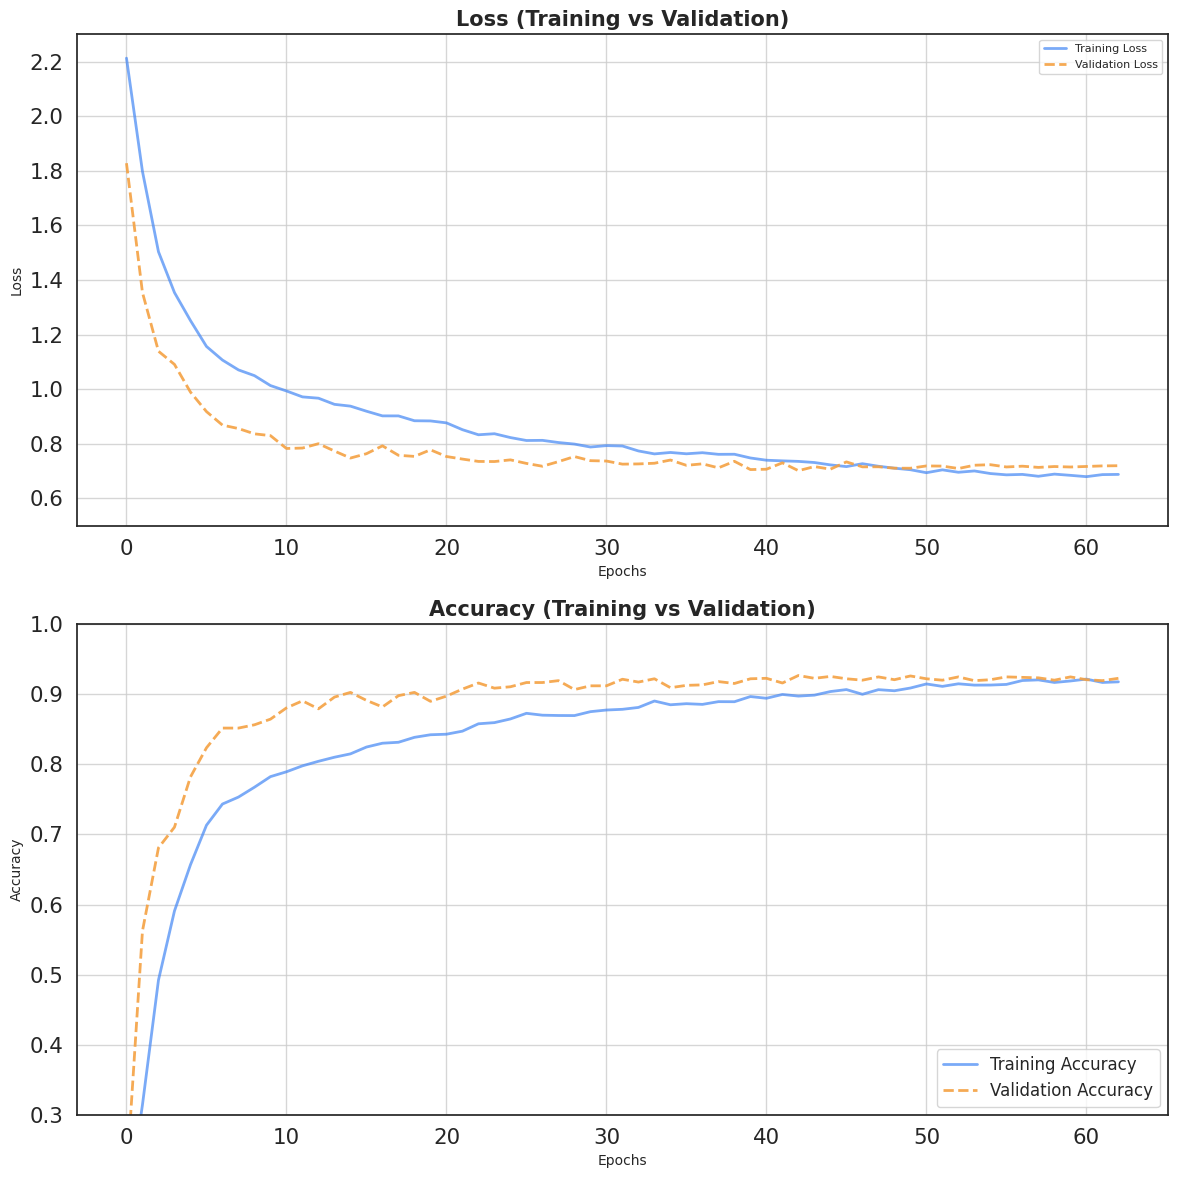

In [26]:
# Create figures and subplots for Loss and Accuracy

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))

# Customize colors and styles.
colors = {
    "train": "#4286f4",  # Blue for the training data
    "val": "#f4a142"     # Orange for the validation data 
}

# Loss Plot
ax1.plot(tl_history_eff['loss'], label='Training Loss', color=colors["train"], linestyle='-', linewidth=2, alpha=0.7)
ax1.plot(tl_history_eff['val_loss'], label='Validation Loss', color=colors["val"], linestyle='--', linewidth=2, alpha=0.9)
ax1.set_title('Loss (Training vs Validation)', fontsize=15, fontweight='bold')
ax1.set_xlabel('Epochs', fontsize=10)
ax1.set_ylabel('Loss', fontsize=10)
ax1.set_ylim(0.5, 2.3)
ax1.legend(loc='upper right', fontsize=8)
ax1.grid(alpha=0.8)

# Accuracy Plot
ax2.plot(tl_history_eff['accuracy'], label='Training Accuracy', color=colors["train"], linestyle='-', linewidth=2, alpha=0.7)
ax2.plot(tl_history_eff['val_accuracy'], label='Validation Accuracy', color=colors["val"], linestyle='--', linewidth=2, alpha=0.9)
ax2.set_title('Accuracy (Training vs Validation)', fontsize=15, fontweight='bold')
ax2.set_xlabel('Epochs', fontsize=10)
ax2.set_ylabel('Accuracy', fontsize=10)
ax2.set_ylim(0.3, 1.0)
ax2.legend(loc='lower right', fontsize=12)
ax2.grid(alpha=0.8)

# Adjust the layout to prevent overlaps.
plt.tight_layout()

# Show the plot.
plt.show()

## Fine-tuning

In [30]:
# Optimizer with exponential decay
optimizer = tf.keras.optimizers.Lion(1e-5)

# ReduceLROnPlateau for fine adjustments
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',  # Monitor validation accuracy
    factor=0.5,              # Halve the learning rate
    patience=7,             # Wait 10 epochs for no improvement
    min_lr=1e-6,             # Minimum learning rate
    verbose=1                # Log learning rate changes
)

In [31]:
eff = tfk.applications.EfficientNetV2L(
    input_shape=(96, 96, 3),
    include_top=False,
    weights='imagenet',
    include_preprocessing=True,
)

# Set all layers as trainable
eff.trainable = True

if all(layer.trainable for layer in eff.layers):
    print("Successful!")
else:
    print("Error!")

# We freeze the first layers, leaving the last 700 (out of 1028) layers unfrozen.
for layer in eff.layers[:-700]:
    layer.trainable = False

# Keep the Batch Normalization layers frozen.
for layer in eff.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

Successful!


In [32]:
# Create a new instance of CustomModel for fine-tuning
ft_model = build_eff_aug()

# Load the weights for the model
ft_model.load_weights('tl.weights.h5')

In [33]:
#FINE-TUNING

#Training
tl_history_eff = ft_model.fit(
    x=X_augmented,
    y=y_train,
    batch_size=64,
    epochs=200,
    validation_data=(X_val, y_val),
    class_weight = class_weights_dict,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True
        ),
        reduce_lr  # Add dynamic learning rate adjustment
    ]
).history

# Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(tl_history_eff['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
model_filename = 'CNN_' + str(final_val_accuracy) + '.keras'
ft_model.save(model_filename)

# Save weights of the Fine Tuning model
ft_model.save_weights('ft.weights.h5')


Epoch 1/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 487s 2s/step - accuracy: 0.8696 - loss: 0.8136 - val_accuracy: 0.9344 - val_loss: 0.6557 - learning_rate: 1.0000e-05
Epoch 2/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 49s 348ms/step - accuracy: 0.9211 - loss: 0.7019 - val_accuracy: 0.9579 - val_loss: 0.6164 - learning_rate: 1.0000e-05
Epoch 3/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 48s 338ms/step - accuracy: 0.9486 - loss: 0.6312 - val_accuracy: 0.9572 - val_loss: 0.6304 - learning_rate: 1.0000e-05
Epoch 4/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 48s 339ms/step - accuracy: 0.9598 - loss: 0.6019 - val_accuracy: 0.9579 - val_loss: 0.6200 - learning_rate: 1.0000e-05
Epoch 5/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 48s 343ms/step - accuracy: 0.9756 - loss: 0.5710 - val_accuracy: 0.9632 - val_loss: 0.6270 - learning_rate: 1.0000e-05
Epoch 6/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 48s 339ms/step - accuracy: 0.9774 - loss: 0.5646 - val_accuracy: 0.9592 - val_loss: 0.6465 - learning_rate: 1.0000e-05
Epoch 7/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 4

## Try on the local test set

In [34]:
# Load the fine-tuned EfficientNetV2-L model for prediction on external images
ft_bn_model = tfk.models.load_model('CNN_97.66.keras')

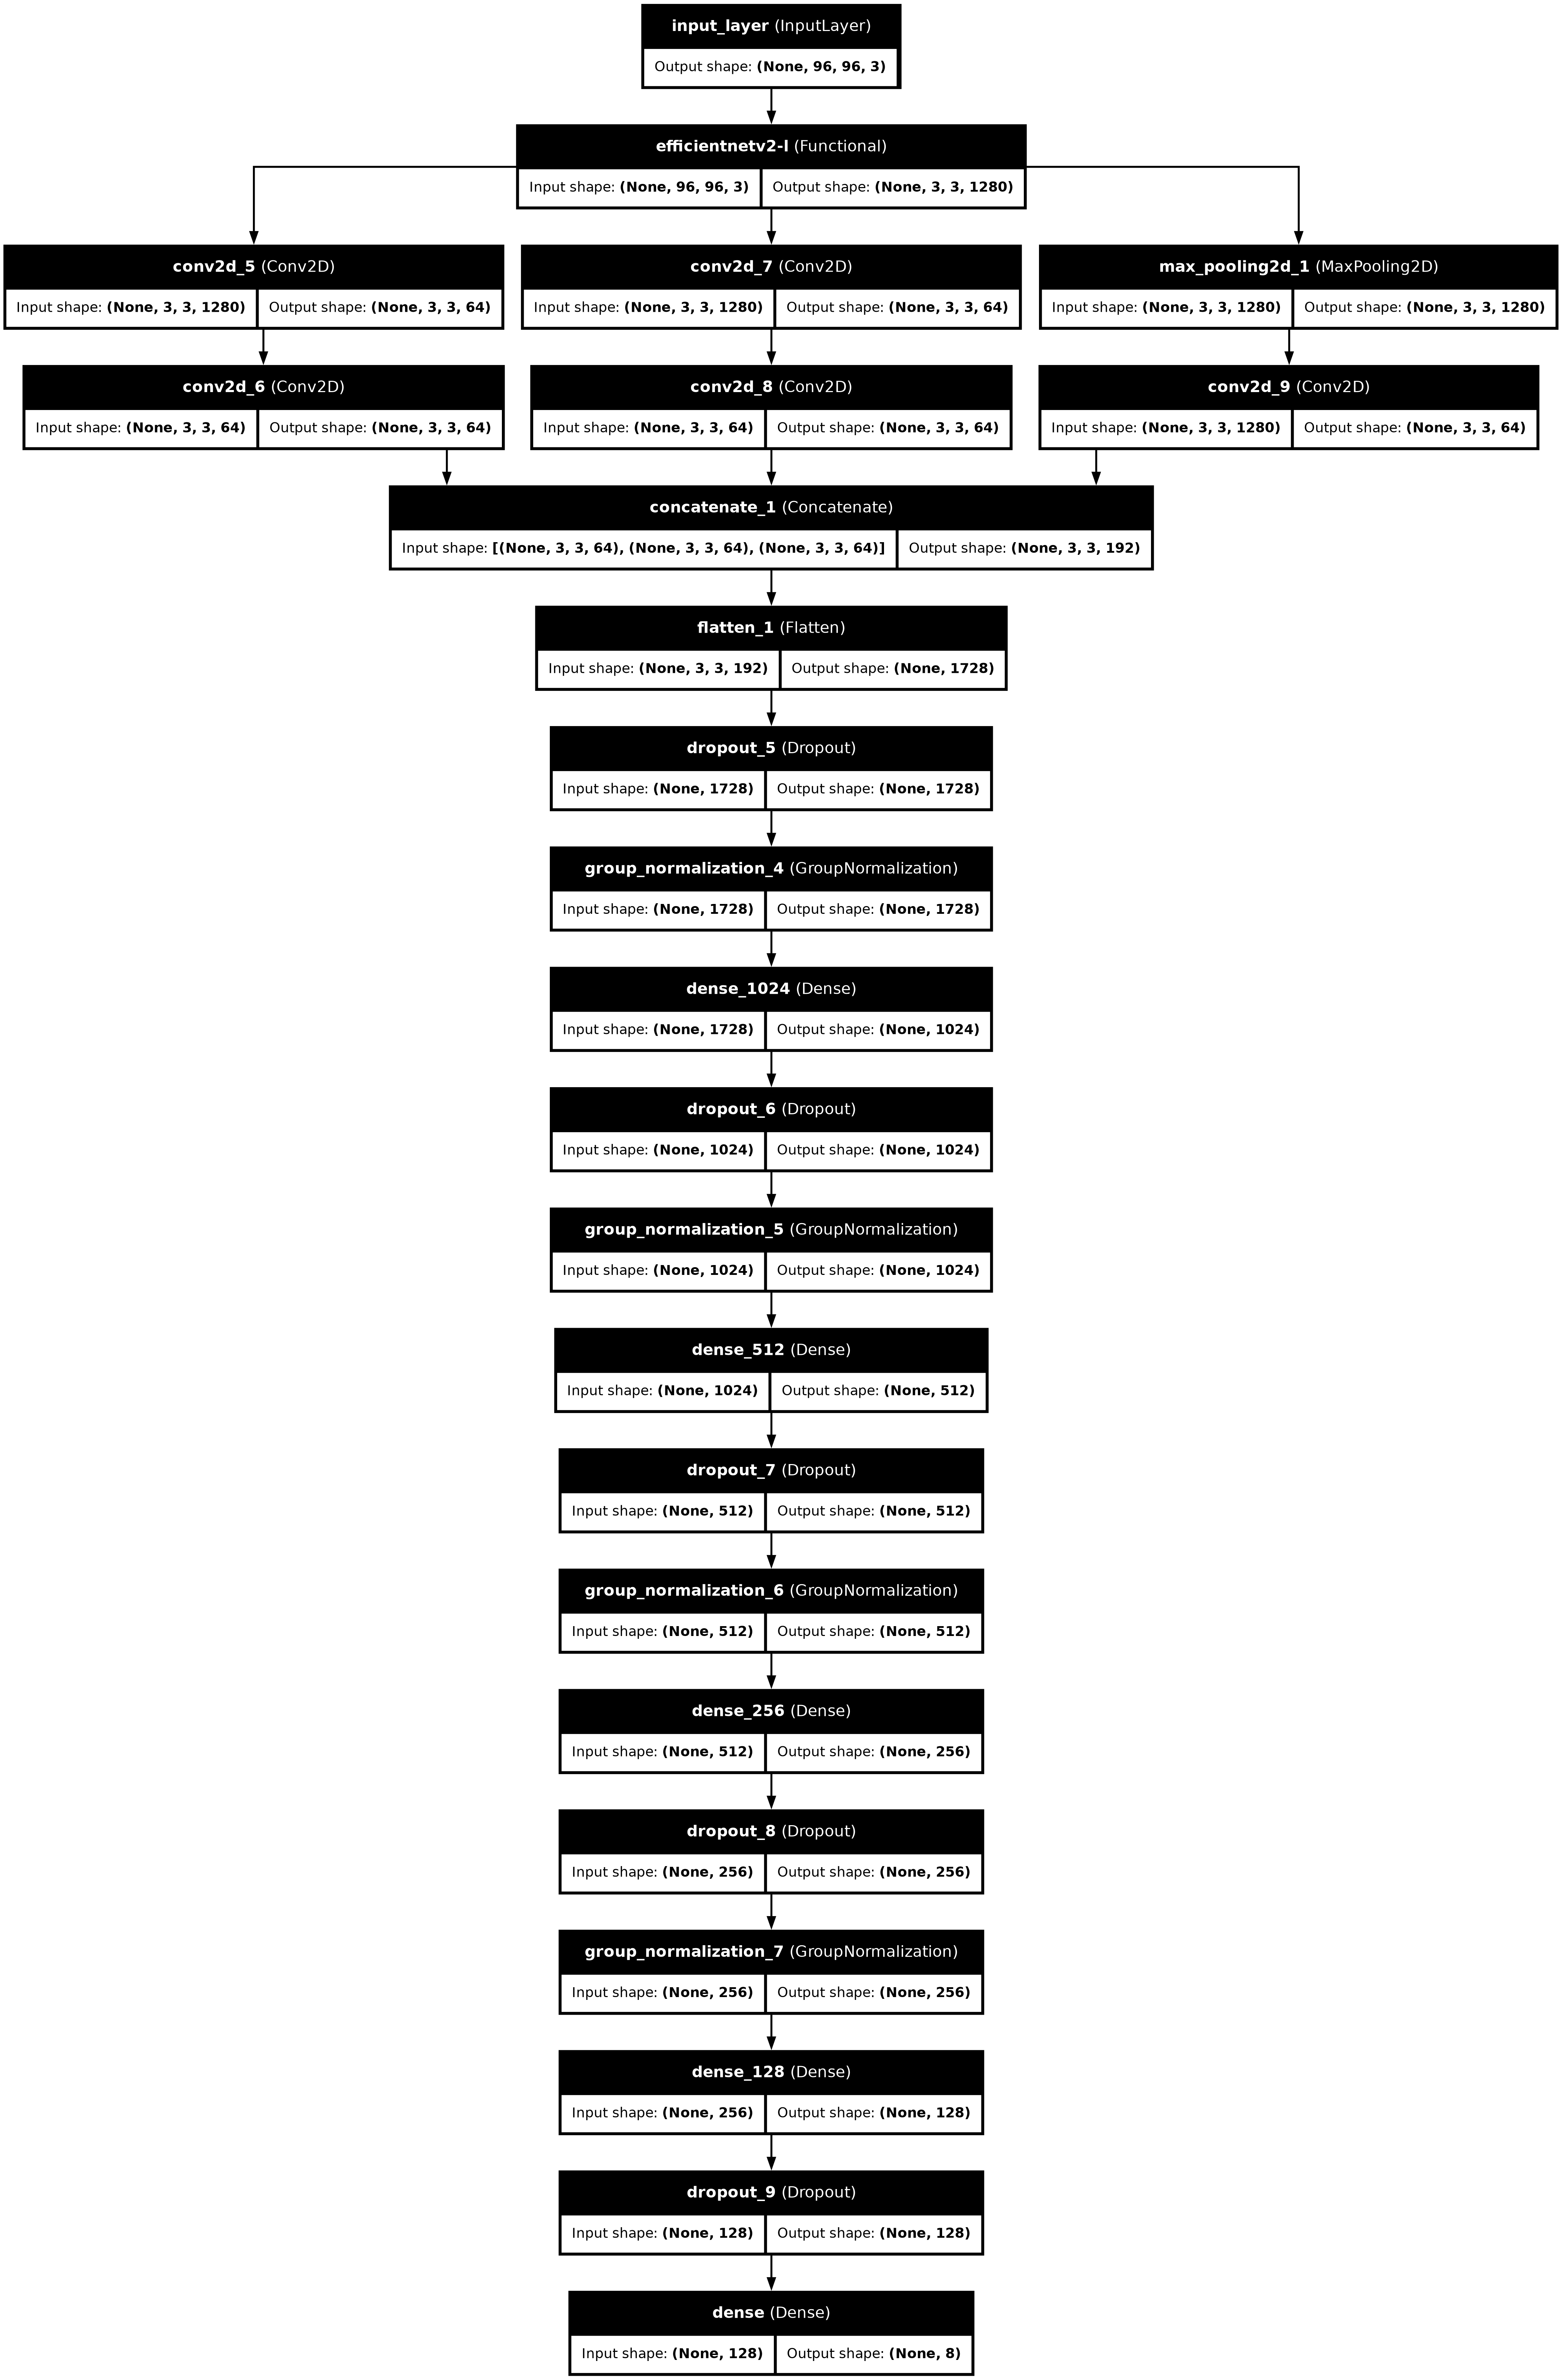

In [35]:
from tensorflow.keras.utils import plot_model

# To visualize the model as an image
plot_model(ft_bn_model, show_shapes=True, show_layer_names=True, to_file='model_structure.png')

In [36]:
# Check that 700 layers out of 1028 are unfrozen, but all the batch normalization layers are frozen.
# EfficientNetV2-L is used as a sub-model or part of the architecture
for i, layer in enumerate(ft_bn_model.get_layer('efficientnetv2-l').layers):
    print(f"Layer {i}: {layer.name}, Trainable: {layer.trainable}")

Layer 0: input_layer_1, Trainable: True
Layer 1: rescaling_1, Trainable: False
Layer 2: stem_conv, Trainable: False
Layer 3: stem_bn, Trainable: False
Layer 4: stem_activation, Trainable: False
Layer 5: block1a_project_conv, Trainable: False
Layer 6: block1a_project_bn, Trainable: False
Layer 7: block1a_project_activation, Trainable: False
Layer 8: block1a_add, Trainable: False
Layer 9: block1b_project_conv, Trainable: False
Layer 10: block1b_project_bn, Trainable: False
Layer 11: block1b_project_activation, Trainable: False
Layer 12: block1b_drop, Trainable: False
Layer 13: block1b_add, Trainable: False
Layer 14: block1c_project_conv, Trainable: False
Layer 15: block1c_project_bn, Trainable: False
Layer 16: block1c_project_activation, Trainable: False
Layer 17: block1c_drop, Trainable: False
Layer 18: block1c_add, Trainable: False
Layer 19: block1d_project_conv, Trainable: False
Layer 20: block1d_project_bn, Trainable: False
Layer 21: block1d_project_activation, Trainable: False
Layer

In [37]:
import keras_cv
import cv2

Accuracy score over the test set: 0.9739
Precision score over the test set: 0.9743
Recall score over the test set: 0.9739
F1 score over the test set: 0.974


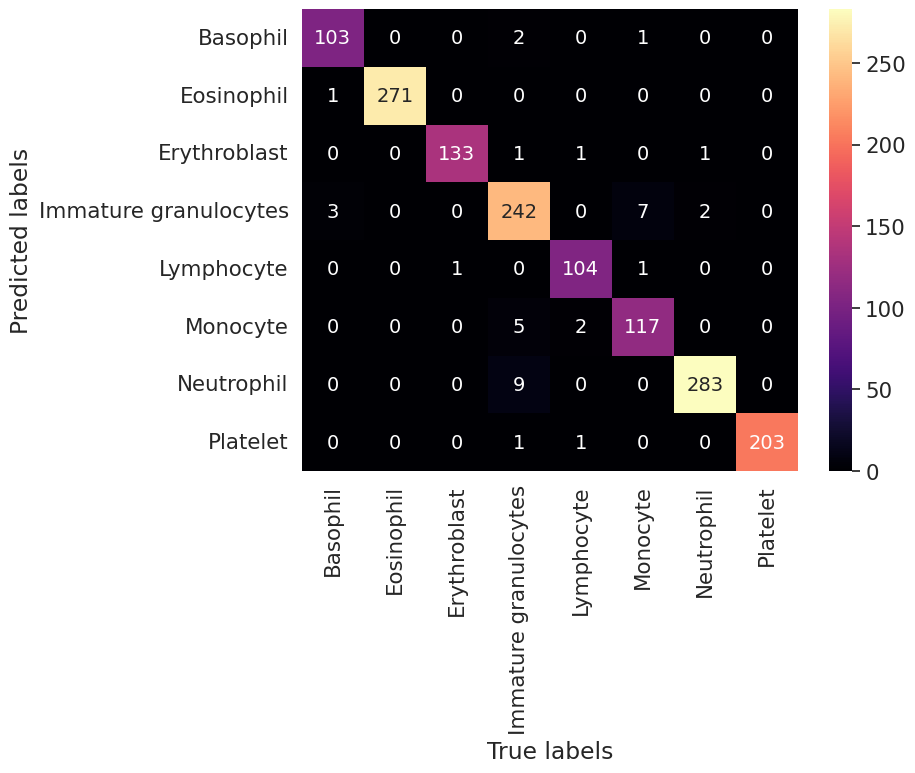

In [38]:
#LOCAL TEST

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
# Predict class probabilities and get predicted classes
test_predictions = ft_bn_model.predict(X_test, verbose=0)
#test_predictions = tta_predict(ft_bn_model, X_test, tta_augmentation)
test_predictions = np.argmax(test_predictions, axis=-1)

# Extract ground truth classes
test_gt = np.argmax(y_test, axis=-1)

# Calculate and display test set accuracy
test_accuracy = accuracy_score(test_gt, test_predictions)
print(f'Accuracy score over the test set: {round(test_accuracy, 4)}')

# Calculate and display test set precision
test_precision = precision_score(test_gt, test_predictions, average='weighted')
print(f'Precision score over the test set: {round(test_precision, 4)}')

# Calculate and display test set recall
test_recall = recall_score(test_gt, test_predictions, average='weighted')
print(f'Recall score over the test set: {round(test_recall, 4)}')

# Calculate and display test set F1 score
test_f1 = f1_score(test_gt, test_predictions, average='weighted')
print(f'F1 score over the test set: {round(test_f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(test_gt, test_predictions)

# Create labels combining confusion matrix values
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix with class labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=labels, fmt='', xticklabels=['Basophil','Eosinophil','Erythroblast','Immature granulocytes','Lymphocyte','Monocyte','Neutrophil','Platelet'], yticklabels=['Basophil','Eosinophil','Erythroblast','Immature granulocytes','Lymphocyte','Monocyte','Neutrophil','Platelet'], cmap='magma')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## Submission

In [39]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    
    def __init__(self):
        
        self.neural_network = tfk.models.load_model('CNN_97.66.keras')

    def predict(self, X):
    
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Writing model.py


In [40]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command
!zip {filename} model.py CNN_97.66.keras

  adding: model.py (deflated 55%)
  adding: CNN_97.66.keras (deflated 6%)


In [41]:
from IPython.display import FileLink
# Generate a link to download the file.
FileLink(filename)

/kaggle/working/submission_241123_113435.zip